In [1]:
#downloading data
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163 (from 1)
Receiving objects: 100% (12163/12163), 156.98 MiB | 12.66 MiB/s, done.
Updating files: 100% (12160/12160), done.


In [2]:
!pip3 install albumentations
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import albumentations as A
import cv2
import pandas as pd
import ntpath
import random

In [3]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.615438


In [4]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


array([-0.96, -0.88, -0.8 , -0.72, -0.64, -0.56, -0.48, -0.4 , -0.32,
       -0.24, -0.16, -0.08,  0.  ,  0.08,  0.16,  0.24,  0.32,  0.4 ,
        0.48,  0.56,  0.64,  0.72,  0.8 ,  0.88,  0.96])

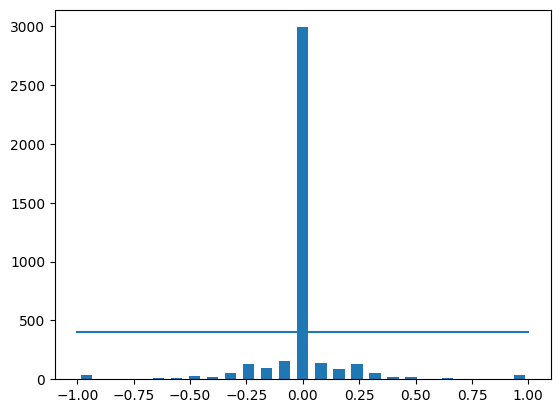

In [5]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
center

total data: 4053
removed: 2590
remaining: 1463


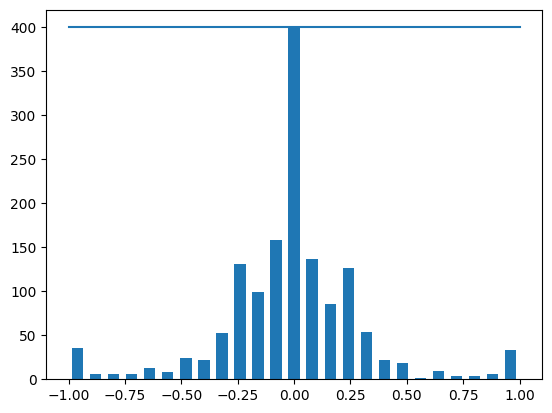

In [6]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [7]:
print(data.iloc[30])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2018_07_16_17_11_47_287.jpg
left          left_2018_07_16_17_11_47_287.jpg
right        right_2018_07_16_17_11_47_287.jpg
steering                              0.406934
throttle                                   1.0
reverse                                    0.0
speed                                 30.10639
Name: 49, dtype: object


<ipython-input-7-0db5afa4e7f2>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
<ipython-input-7-0db5afa4e7f2>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))
<ipython-input-7-0db5afa4e7f2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3])+0.15)
<ipython-input-7-0db5afa4e7f2>:15: Fut

In [8]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

<ipython-input-7-0db5afa4e7f2>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
<ipython-input-7-0db5afa4e7f2>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))
<ipython-input-7-0db5afa4e7f2>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3])+0.15)
<ipython-input-7-0db5afa4e7f2>:15: Fut

In [9]:
len(image_paths)

4389

In [10]:
len(steerings)

4389

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3511
Valid Samples: 878


Text(0.5, 1.0, 'Validation set')

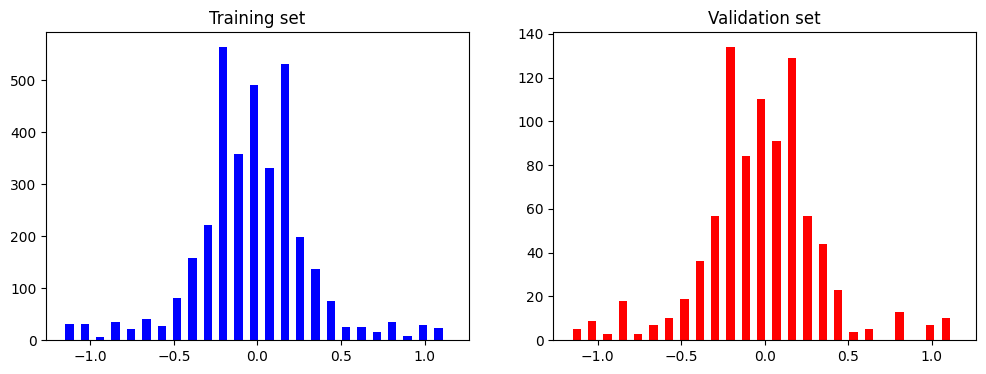

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

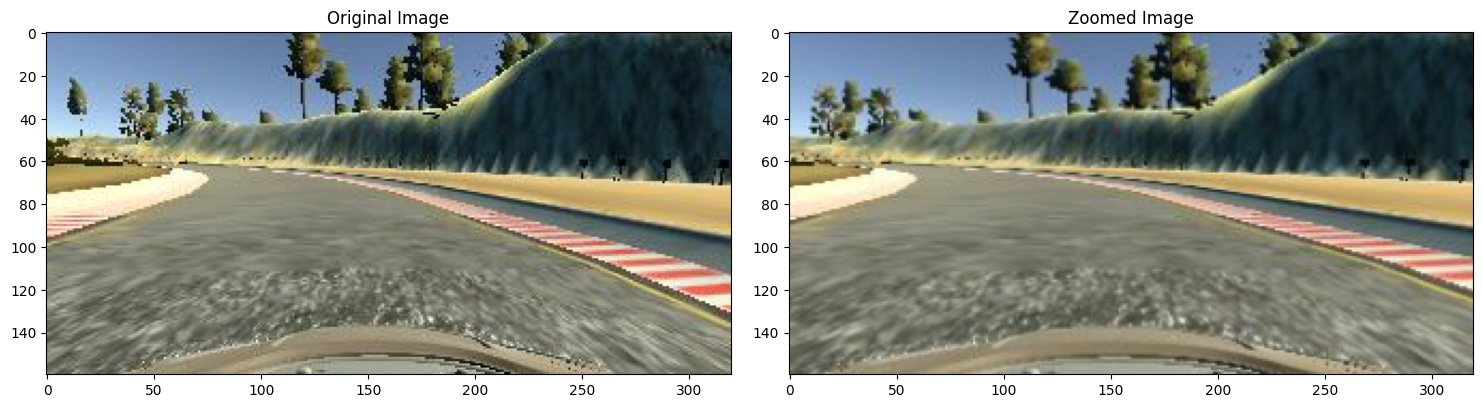

In [13]:

image_paths = ["/content/track/IMG/center_2018_07_16_17_11_43_382.jpg",]

# Corrected zoom function using Albumentations
def zoom(image):
    augmenter = A.Affine(scale=(1.0, 1.3), p=1.0)  # Correct scaling
    augmented = augmenter(image=image)  # Apply transformation
    return augmented["image"]  # Correct way to retrieve the transformed image

# Select a random image correctly
image_path = random.choice(image_paths)  # Picks a valid image randomly
original_image = cv2.imread(image_path)  # Read the image using OpenCV
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

plt.show()

In [14]:
image_paths = ["/content/track/IMG/center_2018_07_16_17_11_43_382.jpg"]
steerings = [0.1]  # Example steering values, replace as needed

# 1️⃣ Function for **Pan (Translation Augmentation)**
def pan(image):
    augmenter = A.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, p=1.0)
    augmented = augmenter(image=image)
    return augmented["image"]

# Select random image
image_path = random.choice(image_paths)
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Apply pan augmentation
panned_image = pan(original_image)

# Plot Pan Augmentation
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')
plt.show()

# 2️⃣ Function for **Random Brightness Augmentation**
def img_random_brightness(image):
    augmenter = A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.2, p=1.0)
    augmented = augmenter(image=image)
    return augmented["image"]

# Apply brightness augmentation
brightness_altered_image = img_random_brightness(original_image)

# Plot Brightness Augmentation
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image')
plt.show()

# 3️⃣ Function for **Flipping Image and Steering Angle**
def img_random_flip(image, steering_angle):
    flipped_image = cv2.flip(image, 1)  # Flip image horizontally
    flipped_steering_angle = -steering_angle  # Reverse steering angle
    return flipped_image, flipped_steering_angle

# Select random image and steering angle
random_index = random.randint(0, len(image_paths) - 1)
image_path = image_paths[random_index]
steering_angle = steerings[random_index]

# Read and process image
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Apply flipping
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

# Plot Flipping Augmentation
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title(f'Original Image - Steering Angle: {steering_angle}')
axs[1].imshow(flipped_image)
axs[1].set_title(f'Flipped Image - Steering Angle: {flipped_steering_angle}')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [15]:
def random_augment(image_path, steering_angle):
    image = mpimg.imread(image_path)

    augmentations = []
    if np.random.rand() < 0.5:
        augmentations.append(A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=1.0))
    if np.random.rand() < 0.5:
        augmentations.append(A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0))
    if np.random.rand() < 0.5:
        augmentations.append(A.HorizontalFlip(p=1.0))
        steering_angle = -steering_angle  # Flip the angle when flipping horizontally

    transform = A.Compose(augmentations)
    augmented = transform(image=image)

    return augmented['image'], steering_angle

ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(nrow):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axs[i, 0].imshow(original_image)
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(augmented_image)
    axs[i, 1].set_title("Augmented Image")
    axs[i, 1].axis("off")

plt.show()




Output hidden; open in https://colab.research.google.com to view.

In [16]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

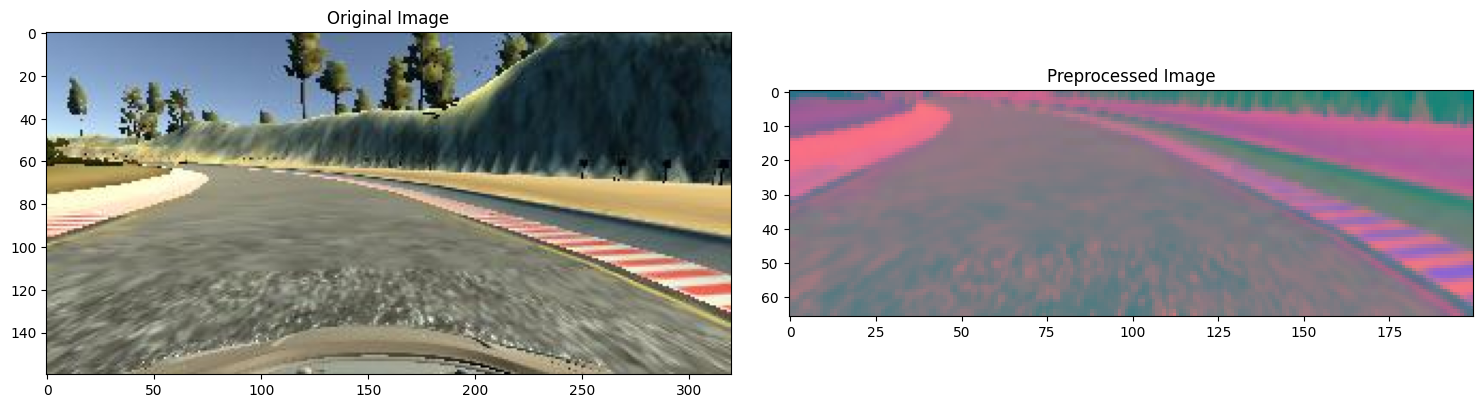

In [17]:
image_paths = ["/content/track/IMG/center_2018_07_16_17_11_43_382.jpg"]
steerings = [0.1]  # Example steering values

# 1️⃣ Image Preprocessing Function
def img_preprocess(img):
    img = img[60:135, :, :]  # Crop out the sky and car hood
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  # Convert to YUV (better for deep learning)
    img = cv2.GaussianBlur(img, (3, 3), 0)  # Apply Gaussian Blur
    img = cv2.resize(img, (200, 66))  # Resize to NVIDIA model input size
    img = img / 255.0  # Normalize pixel values
    return img

# Read and preprocess image
image_path = image_paths[0]
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

preprocessed_image = img_preprocess(original_image)

# Plot Original vs Preprocessed Image
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')
plt.show()

# 2️⃣ Batch Generator with Albumentations
def batch_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steerings = []

        for _ in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            steering = steering_angles[random_index]

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if is_training:
                image, steering = random_albumenter(image_path, steering)

            image = img_preprocess(image)  # Apply preprocessing
            batch_images.append(image)
            batch_steerings.append(steering)

        yield (np.asarray(batch_images), np.asarray(batch_steerings))

In [18]:
  !nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [19]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [20]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

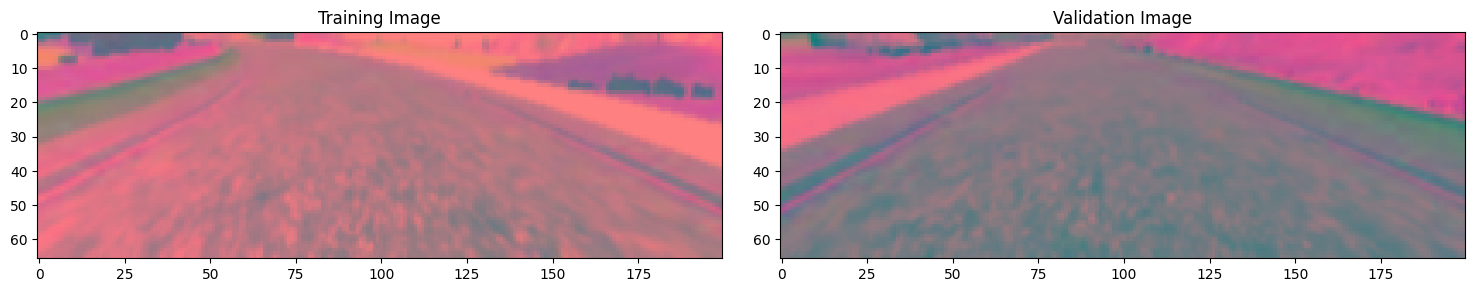

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [22]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5), activation='elu'))
  # model.add(Conv2D(64, (3,3), activation='elu'))
#   model.add(Dropout(0.5))


  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 18, 64)      │        76,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,443 (1.01 MB)

 Trainable params: 264,443 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:

history = model.fit(
    x=batch_generator(X_train, y_train, 100, 1),
    steps_per_epoch=300,
    epochs=10,
    validation_data=batch_generator(X_valid, y_valid, 100, 0),
    validation_steps=200,
    verbose=1,
    shuffle=True  # or False, depending on your needs
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - loss: 0.3353 - val_loss: 0.0665
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.0678 - val_loss: 0.0502
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - loss: 0.0634 - val_loss: 0.0429
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - loss: 0.0556 - val_loss: 0.0405
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - loss: 0.0488 - val_loss: 0.0316
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - loss: 0.0466 - val_loss: 0.0335
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - loss: 0.0436 - val_loss: 0.0274
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - loss: 0.0432 - val_loss: 0.0268
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - loss: 0.0411 - val_loss: 0.0263
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - loss: 0.0406 - val_loss: 0.0275


Text(0.5, 0, 'Epoch')

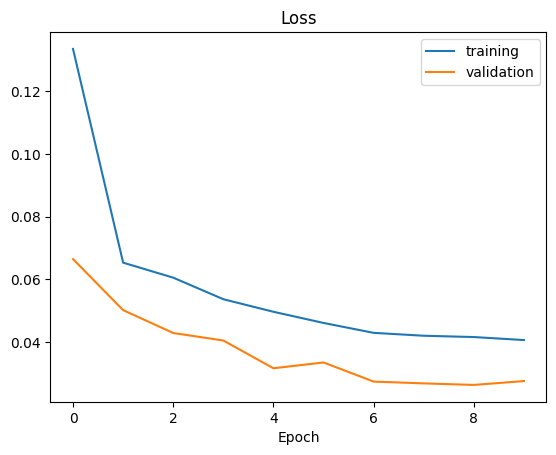

In [24]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [26]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>